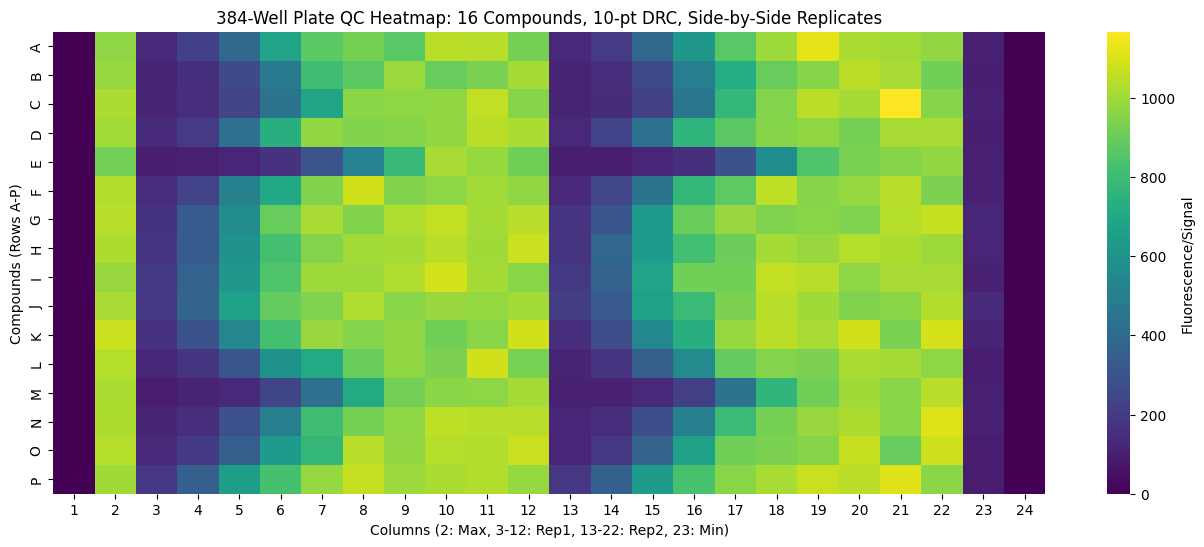

/tmp/ipython-input-1176165742.py:23: RuntimeWarning: invalid value encountered in power
  return bottom + (top - bottom) / (1 + (x / ic50)**hill_slope)



--- Summary of Calculated Potencies ---
   Compound Row  IC50_uM
 Compound 1   A   1.6996
 Compound 2   B   0.9231
 Compound 3   C   0.7144
 Compound 4   D   2.3024
 Compound 5   E   0.1318
 Compound 6   F   2.4354
 Compound 7   G   3.7354
 Compound 8   H   4.9232
 Compound 9   I   4.4562
Compound 10   J   4.6909
Compound 11   K   2.9746
Compound 12   L   1.2648
Compound 13   M   0.2516
Compound 14   N   0.9168
Compound 15   O   1.5088
Compound 16   P   4.4098


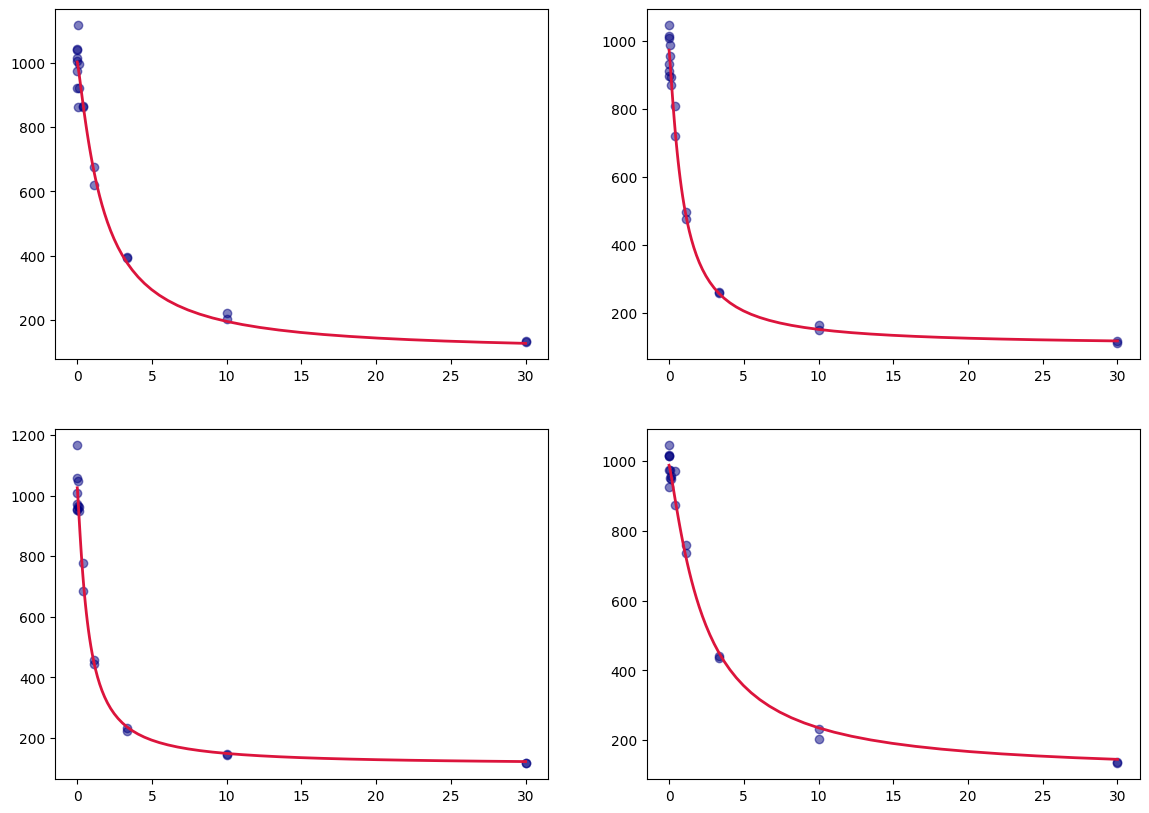

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# =================================================================
# 1. EXPERIMENTAL DESIGN & DATA SIMULATION
# =================================================================
# 384-well Plate Setup: 16 Compounds (Rows A-P) x 24 Columns
rows = [chr(i) for i in range(ord('A'), ord('Q'))]
cols = [i for i in range(1, 25)]
plate_data = np.zeros((16, 24))

# 10-point, 3-fold serial dilution starting at 30uM
start_conc = 30.0
dilution_factor = 3
concentrations = [start_conc / (dilution_factor**i) for i in range(10)]
x_data = np.array(concentrations * 2) # Conc repeated for Replicate 1 & 2

# 4-Parameter Logistic (4PL) Model for IC50 Fitting
def logit_4pl(x, top, bottom, ic50, hill_slope):
    return bottom + (top - bottom) / (1 + (x / ic50)**hill_slope)

# Simulate varied compound potency across the plate
np.random.seed(42)
for r_idx in range(16):
    # Randomize a "True IC50" for simulation variety (range 0.1 to 5.0 uM)
    true_ic50 = np.random.uniform(0.1, 5.0)

    # Column 2: Max Control | Column 23: Min Control
    plate_data[r_idx, 1] = np.random.normal(1000, 30)
    plate_data[r_idx, 22] = np.random.normal(100, 10)

    # Calculate sigmoidal response for the DRC
    response = logit_4pl(np.array(concentrations), 1000, 100, true_ic50, 1.2)

    # Fill Rep 1 (Cols 3-12) and Rep 2 (Cols 13-22) with 5% technical noise
    plate_data[r_idx, 2:12] = np.random.normal(response, response * 0.05)
    plate_data[r_idx, 12:22] = np.random.normal(response, response * 0.05)

# Convert to DataFrame for easier handling
df_plate = pd.DataFrame(plate_data, index=rows, columns=cols)

# =================================================================
# 2. VISUAL QUALITY CONTROL (PLATE HEATMAP)
# =================================================================
plt.figure(figsize=(16, 6))
sns.heatmap(df_plate, cmap="viridis", cbar_kws={'label': 'Fluorescence/Signal'})
plt.title("384-Well Plate QC Heatmap: 16 Compounds, 10-pt DRC, Side-by-Side Replicates")
plt.xlabel("Columns (2: Max, 3-12: Rep1, 13-22: Rep2, 23: Min)")
plt.ylabel("Compounds (Rows A-P)")
plt.show()

# =================================================================
# 3. AUTOMATED ANALYTICS: FULL-PLATE IC50 FITTING
# =================================================================
ic50_results = []

for r_idx in range(16):
    y_data = plate_data[r_idx, 2:22]

    try:
        # Perform Non-Linear Least Squares Regression
        popt, _ = curve_fit(logit_4pl, x_data, y_data, p0=[1000, 100, 1.0, 1.0])
        top_f, bot_f, ic50_f, slope_f = popt

        ic50_results.append({
            'Compound': f"Compound {r_idx+1}",
            'Row': rows[r_idx],
            'IC50_uM': round(ic50_f, 4),
            'Top': round(top_f, 1),
            'Bottom': round(bot_f, 1)
        })
    except Exception as e:
        ic50_results.append({'Compound': f"Compound {r_idx+1}", 'Row': rows[r_idx], 'IC50_uM': "Fit Failed"})

results_df = pd.DataFrame(ic50_results)

# =================================================================
# 4. DATA VALIDATION: SAMPLE DOSE-RESPONSE CURVES
# =================================================================
print("\n--- Summary of Calculated Potencies ---")
print(results_df[['Compound', 'Row', 'IC50_uM']].to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i in range(4):
    y_vals = plate_data[i, 2:22]
    row_data = results_df.iloc[i]

    # Check if fit was successful
    if isinstance(row_data['IC50_uM'], float):
        ic50_val = row_data['IC50_uM']
        # Generate smooth curve for plotting
        x_smooth = np.logspace(np.log10(min(concentrations)), np.log10(max(concentrations)), 100)
        y_smooth = logit_4pl(x_smooth, row_data['Top'], row_data['Bottom'], ic50_val, 1.2)

        axes[i].scatter(x_data, y_vals, color='navy', alpha=0.5, label='Replicates')
        axes[i].plot(x_smooth, y_smooth, color='crimson', lw=2, label=f'Fit (IC50: {ic50_val} µM)')
        axes[i].set_xscale